In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np

In [ ]:
#Adicionando dados ao dataframe
df = pd.read_csv('../data/insurance.csv')
#Transformando Váriaveis Categóricas em Numéricas
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'male' else 0)
df['smoker'] = df['smoker'].apply(lambda x: 1 if x == 'yes' else 0)
df['region'] = df['region'].apply(lambda x: 0 if x == 'southwest' else 1 if x == 'southeast' else 2 if x == 'northwest' else 3)

In [ ]:
#Conjunto de testes para diferentes conjuntos de treino
X = df.drop(columns=['charges']) #Selecionando Dados de Input
y = df['charges'] #Selecionando Target
erros = [] #Lista para armazenar os erros de cada teste
#Função para calcular o erro percentual médio
def erro_percentual_medio_teste(Y_true, Y_pred):
    erro = 0
    for i in range(len(Y_true)):
        erro += (Y_pred[i]- Y_true.values[i][0])/Y_true.values[i][0]
    return erro/len(Y_true)
#Realizando 100 testes
for i in range(100):
    #Separando os dados de treino(70%) e teste(30%) aleatoriamente a cada iteração
    X_train,X_test,Y_train,Y_true = train_test_split(df[['age','sex','bmi','children','smoker','region']],df[['charges']],test_size=0.3,random_state=i)
    #Criando Modelo
    model = xgb.XGBRegressor(max_depth=6, #Profundidade Máxima da Árvore (Número de Nós)
                             learning_rate=0.1, #Taxa de aprendizado
                             n_estimators=100 #Número de árvores
                             )
    model.fit(X_train,Y_train) #Treinando o Modelo
    Y_pred = model.predict(X_test) #Realizando Previsões
    erros.append(erro_percentual_medio_teste(Y_true,Y_pred)) #Adicionando Métrica de Erro ao vetor de erros


In [ ]:
#Arquivo que pode ser usado por aplicação para gerar novas previsões
model.save_model('model.json') #Salvando o Modelo

Text(0.5, 1.0, 'Histograma de Média de Erro Por Pessoa - 100 Testes')

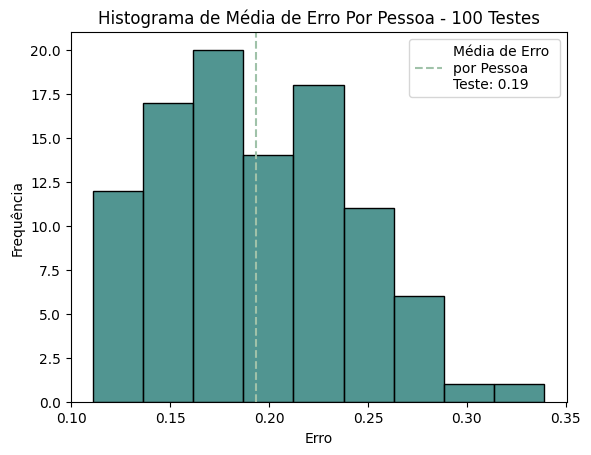

In [ ]:
#Histograma de Erros em cada Teste
import seaborn as sns
import matplotlib.pyplot as plt
erros = np.array(erros)
sns.histplot(erros,color='#17726d')
tamanho_teste = len(df['charges'])*0.3
plt.axvline(np.mean(erros),color='#a0c2a9',label=f'Média de Erro \npor Pessoa \nTeste: {(np.mean(erros)).round(2)}',linestyle='--')
plt.legend(loc='upper right')
plt.xlabel('Erro')
plt.ylabel('Frequência')
plt.title('Histograma de Média de Erro Por Pessoa - 100 Testes')